## --------MARKING LANE LINES AND DETERMINING RADIUS OF CURVATURE OF ROAD ------

#### INTRODUCTION:
Lane detection and radius of curvature determination are very much important for any high level algorithm to predict the required steering angle and accelaration in sel-driven cars. So, algorithms developed to identify lane lines and curvature along with the position of the vehicle in the lane should be fast and accurate enough to be observed in real-time. In this project I try to present a novel idea based on advanced computer vision techniques that stand still in most of the conditions. The important aspects that any algorithm should look into while solving for this problem are shadows and sudden changes in sun light intensitties. So, we convert our image space from RGB to HSV or HSL and create thresholds on saturation values for Region of interest.

#### METHODOLOGY:
This problem is split into two sub-problems. The first sub-problem deals with identifying potential regions inthe image that can contribute to be part of a lane. This is achieved by applying cv techniques that shall be discussed clearly in upcoming steps. The second sub-problem deals with marking lane lines using windows on the original frame to compute radius of curvature and removal of noise and disttubances in the lane lines obtianed by taking into consideration of previous frame lane data.

#### Problem 1: Creating a mask that can detect lanes
The computer vision techniques employed in creating a mask are undistorting, perspective transformation, color masking and sobel filter. All these techniques are used as functions from OpenCV libraries. The design heirarchy is divided into following steps.

1. Read an image from the dataset and undistort using pre-computed distortion camera matrix.
2. Apply perspective transform on undistorted image to have a bird's eye view of the road. Warping the image to right region of interest does good help in further processing of the frame.
3. Shifting the colour space from RGB to either HSV or HSL helps to figure out more data with less effort. HSV values for Yellow range from [0,100,100] to [80,255,255], and for white colour they range from [0,0,210] to [200,50,255]. 'H' or HUE stands for the colour itself , 'S' stands for SATURATION or the amount of colour, and 'V' stands for VALUE or the amount of brighness applied over that colour. As the important aspect of this problem is to find lanes even with heavy variations of brightness, shifting the colour space from RGB to HSV will do a good job. 
4. Once the color mask is applied on the image the next step is to detect the edges from the masked image. Sobel filter is applied on H, L channels of the warped image as these channels show very mimimal change with lighting variations. Sobel filter is applied along X and Y directons independently and a bitwise OR operation is performed on the the masks to obtain a final mask. After many number of iterations the threshold values from 50 to 225 were choosen to be appropriate.
5. For the final step of stage 1 pixels from Colour and Sobel masks are combined to obtain potential lane locations.

#### Problem 2: Computing Curvature
The above methodologies work only in the conditions when the lanes are visible to a good extent, so we need some better way that can propogate the lane forward when there are small disturbances covering parts of the road, like snow, dust, wear and tear. For this reason we run a small window of 50 pixels along the center of the lanes computed in the previous frames. This windowing technique applied from the second frame can help reduce the computation time to a great extent and also helps in continuous propogation of lane. Two correction steps are also followed along with the previous steps to keep the lane smooth, they are outlier removal and smoothing. Pixels are marked as outliers if their width is found to be less than 5 pixles and if coffecient change is more than 0.01 is introduced because of it. A factor of 0.01 is taken keeping vehicle turn radius as atleast 7m corresponding to short side lane  curvature. Smoothing is achieved by adopting 90 percent of previous coefficients into the present quadratic coefficient values. Using these coefficients of new polynomial fit we compute the curvature of the lane and relative location of the car in the lane. Followings steps are the pipeline for this stage.

1. Consider only half of the image that is masked and compute histogram, and we find the lane locations at the two peaks of histogram corresponding to left and right lanes of the road in the masked image.
2. The next step is placing a window of size 50x50 pixels on the bottom 10th part of the image by centering the windows the peaks located in the previous step and propagate forward in the same way to next sections of the image and to upcoming frames. In case if no peaks were found in the previous link we place the window at a location with offset from previous computed center.
3. Now we try fit a quadratic fit polynomial using numpys polyfit function.
4. If the current frame is not the first frame we follow the pervious steps for computation and the next step is outlier removal. If a lane was found with less than 5 pixels it is discarded and the previous coefficients are used in the place of current.
5. However smoothing is required on the lanes, so previous curve coefficients are used along the current values. This helps smooth shifting of lane curvature.
6. Finally the lane curvature and position of car on the lane are computed and reverse marked on the unwarped perspective image.


### The step by step implementation of the above system is derived in Solution_1.ipynb . This jupyter notebook only deals with the pipepline that is implemented on the video directly.

# Solution :

In [1]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import pickle
import math
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import Image as ipimag
from PIL import Image as pimag
import glob
outdir= "modelsol"
outdir1="video2image"
pi = 3.14159
% matplotlib inline
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]
kernel = 5
window = 60

In [18]:
#Functions for the main pipeline are defined here 
def undistort_image(image,mtx,dist):
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undist_image
def gaussian_blur(image,kernel=5):
    blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return blur_image
def clahe(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=0.8, tileGridSize=(6,6))    
    transform = clahe.apply(v)
    res= cv2.merge((h,s,transform))
    res = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
    return res
def abs_sobel(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output
def mag_thresh(img, sobel_kernel=3, thresh=(20,100)):
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))    
    binary_output = 0*grad_s 
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut
def warp_image(img,src,dst,shape):
    Mat = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, Mat, shape, flags=cv2.INTER_LINEAR)
    Mat_inv = cv2.getPerspectiveTransform(dst, src)
    return warped,Mat,Mat_inv
def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask
def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def get_first(img,window):
    
    # This function gets the initial mask
    
    img = gaussian_blur(img,5)
    shape = np.shape(img)
    mov_filtsize = shape[1]/50.
    hista = np.mean(img[int(shape[0]/2):,:],axis=0)
    hista = moving_average(hista,mov_filtsize)
    
    peaks = find_peaks_cwt(hista,[100], max_distances=[800])

    valid_peaks = np.array([hista[peaks[i]] for i in range(len(peaks)) ])
    peaks_sorted = np.argsort(-valid_peaks)

    R_peak = peaks[peaks_sorted[0]]
    L_peak = peaks[peaks_sorted[1]]
    if R_peak<L_peak:
        temp = R_peak
        R_peak = L_peak
        L_peak = temp

    n_vals = 8
    ind_min_L = L_peak-window
    ind_max_L = L_peak+window

    ind_min_R = R_peak-window
    ind_max_R = R_peak+window

    Left_mask = np.zeros_like(img)
    Right_mask = np.zeros_like(img)

    pre_R_peak = R_peak
    pre_L_peakv = L_peak
    
    # Split image into 8 parts and compute histogram on each part
    
    for i in range(8):
        img_y1 = int(shape[0]-shape[0]*i/8)
        img_y2 = int(shape[0]-shape[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        peaks = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(peaks)>1.5:
            valid_peaks = np.array([hista[peaks[i]] for i in range(len(peaks)) ])
            peaks_sorted = np.argsort(-valid_peaks)

            R_peak = peaks[peaks_sorted[0]]
            L_peak = peaks[peaks_sorted[1]]
            if R_peak<L_peak:
                temp = R_peak
                R_peak = L_peak
                L_peak = temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(peaks)==1:
                if (np.abs(peaks[0]-pre_R_peak)<np.abs(peaks[0]-pre_L_peakv)):
                    R_peak = peaks[0]
                    L_peak = pre_L_peakv
                else:
                    L_peak = peaks[0]
                    R_peak = pre_R_peak
            else:
                L_peak = pre_L_peakv
                R_peak = pre_R_peak
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(L_peak-pre_L_peakv)>=60:
            L_peak = pre_L_peakv

        if np.abs(R_peak-pre_R_peak)>=60:
            R_peak = pre_R_peak
            
    
            
        Left_mask[img_y2:img_y1,int(L_peak-window):int(L_peak+window)] = 1.
        Right_mask[img_y2:img_y1,int(R_peak-window):int(R_peak+window)] = 1.
        
        pre_L_peakv = L_peak
        pre_R_peak = R_peak
        
    return Left_mask,Right_mask
def get_mask(image, polynomial_fit,window):
    mask = np.zeros_like(image)
    shape = np.shape(image)
    
    polynomial_points = []
    points = []
    
    for i in range(8):
        image_y1 = int(shape[0]-shape[0]*i/8)
        image_y2 = int(shape[0]-shape[0]*(i+1)/8)
        
        point = (image_y1+image_y2)/2
        points.append(point)
        polynomial_point = np.round(polynomial_fit[0]*point**2 + polynomial_fit[1]*point + polynomial_fit[2])
        polynomial_points.append(polynomial_point)
        
        mask[image_y2:image_y1,int(polynomial_point-window):int(polynomial_point+window)]=1.
        
    return mask,np.array(polynomial_points),np.array(points)

def get_val(y,polynomial):
    return polynomial[0]*y**2 + polynomial[1]*y + polynomial[2]

def draw_pw_lines(image,points,colour):
    points = np.int_(points)
    for i in range(10):
        x1 = points[0][i][0]
        y1 = points[0][i][1]
        x2 = points[0][i+1][0]
        y2 = points[0][i+1][1]
        cv2.line(image,(x1,y1),(x2,y2),colour,40)
        
def draw_mid_lines(image,points1,points2,colour):
    points1 = np.int_(points1)
    points2 = np.int_(points2)
    points_x=[]
    points_y=[]
    for i in range(10):
        x1 = (points1[0][i][0]+points2[0][i][0])//2
        y1 = points1[0][9-i+1][1]
        x2 = (points1[0][i+1][0]+points2[0][i+1][0])//2
        y2 = points1[0][9-i][1]
        cv2.line(image,(x2,y2),(x1,y1),colour,20)
        


def get_curvature(polynomial,points):
    A = polynomial[0]
    B = polynomial[1]
    curvature = ((1+(2*A*points+B)**2)**1.5)/2/A
    return curvature

def stack_arr(array):
    return np.stack((array,array,array),axis=2)

def apply_perspective_transform(image):
    # Applies bird-eye perspective transform to an image
    shape = image.shape
    ht_window = np.uint(shape[0]/1.5)
    hb_window = np.uint(shape[0])
    c_window = np.uint(shape[1]/2)
    ctl_window = c_window - .25*np.uint(shape[1]/2)
    ctr_window = c_window + .25*np.uint(shape[1]/2)
    cbl_window = c_window - 1*np.uint(shape[1]/2)
    cbr_window = c_window + 1*np.uint(shape[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,shape[0]],[shape[1],shape[0]],
                  [shape[1],0],[0,0]])
    
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(shape[1],shape[0])) # returns birds eye image
    return warped,M_warp,Minv_warp

In [19]:
def threshold_image(img):
    kernel = np.ones((14,14),np.uint8)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    
    hls_l = hls[:,:,1]
    th_hls_l = cv2.morphologyEx(hls_l, cv2.MORPH_TOPHAT, kernel)
    hls_l_binary = np.zeros_like(th_hls_l)
    hls_l_binary[(th_hls_l > 20) & (th_hls_l <= 255)] = 1

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
    lab_l = lab[:,:,0]
    th_lab_l = cv2.morphologyEx(lab_l, cv2.MORPH_TOPHAT, kernel)
    lab_l_binary = np.zeros_like(th_lab_l)
    lab_l_binary[(th_lab_l > 20) & (th_lab_l <= 255)] = 1

    lab_b = lab[:,:,2]
    th_lab_b = cv2.morphologyEx(lab_b, cv2.MORPH_TOPHAT, kernel)
    lab_b_binary = np.zeros_like(th_lab_b)
    lab_b_binary[(th_lab_b > 5) & (th_lab_b <= 255)] = 1

    full_mask = np.zeros_like(th_hls_l)
    full_mask[(hls_l_binary == 1) | (lab_l_binary == 1) | (lab_b_binary == 1)] = 1

    kernel = np.ones((6,3),np.uint8)
    erosion = cv2.erode(full_mask,kernel,iterations = 1)

    return erosion

In [33]:
def pipeline(image):
    
    global pre_L_fit   
    global pre_R_fit
    global col_R_prev
    global col_L_prev
    global set_prev
    global Left_mask
    global Right_mask
    

    # Undistort image

    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    shape = np.shape(image)
    
    # Define window for perspective transform
    warped,M_warp,Minv_warp = apply_perspective_transform(image)
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 20, 80, 50])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  0,   0,   200])
    white_hsv_high = np.array([ 255, 40, 255])
    # get yellow and white masks 
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    # Combine white and yellow masks into 1
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    # Convert image to HLS scheme
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel(img_gs,'x',5,(80,225))
    img_abs_y = abs_sobel(img_gs,'y',5,(150,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel(img_gs,'x',5,(80,255))
    img_abs_y = abs_sobel(img_gs,'y',5,(150,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    

    # Combine sobel filter information from L and S channels.
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    

    # Combine masks from sobel and color masks.

    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.6)]=1
    
    
    # If this is first frame, get new mask.
    if set_prev == 0:
        image_cmb1 = gaussian_blur(image_cmb1,5)
        Left_mask,Right_mask = get_first(image_cmb1,40)

        
        
    # Define all colors as white to start.         
    col_R = (255,255,0)
    col_L = (255,255,0)
    
    # Apply mask to sobel images and compute polynomial fit for left. 
    img_L = np.copy(image_cmb1)
    img_L = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = Left_mask)
    vals = np.argwhere(img_L>.5)
    if len(vals)<5: ## If less than 5 points 
        left_fit = pre_L_fit
        col_L = col_L_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
            col_L = (255,255,0)
            
    # Apply mask to sobel images and compute polynomial fit for right. 

    img_R = np.copy(image_cmb1)
    img_R = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = Right_mask)
    vals = np.argwhere(img_R>.5)
        
    if len(vals)<5:
        right_fit = pre_R_fit
        col_R = col_R_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
            col_R = (255,255,0)
    
    
    ## assign initial mask, and save coefficient values for next frame
            
    if set_prev == 0:
        set_prev = 1
        pre_R_fit = right_fit
        pre_L_fit  = left_fit
    
       
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-pre_R_fit[0])**2) #/np.sum(pre_R_fit[0]**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = pre_R_fit
        col_R = col_R_prev
    else:
        right_fit = .4*right_fit+.6*pre_R_fit
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-pre_L_fit[0])**2) #/np.sum(pre_R_fit[0]**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit = pre_L_fit
        col_L = col_L_prev
    else:
        left_fit =  .4* left_fit+.6* pre_L_fit
    

    ## Compute lane mask for future frame 
    Left_mask,left_pts,img_pts = get_mask(image_cmb1,left_fit,window)
    Right_mask,right_pts,img_pts = get_mask(image_cmb1,right_fit,window)
     
        
    ## Compute lanes
        
    right_y = np.arange(11)*shape[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*shape[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    

    ## Compute intercepts
    left_bot = get_val(shape[0],left_fit)
    right_bot = get_val(shape[0],right_fit)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    ## Compute lane offset
    dist_offset = val_center - shape[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,100, 200))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,100,200))
        
    color_warp_d = color_warp
    #mid_level = np.int_(pts_left-val_center)
    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp_d,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp_d,np.int_(pts_right),col_R)
    #draw_mid_lines(color_warp_d,np.int_(pts_left),np.int_(pts_right),(255,0,0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    #newwarp_d = cv2.warpPerspective(color_warp_d, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.75, 0)
    #result = cv2.addWeighted(result, 1, newwarp_d, 0.75, 0)
    
    left_curve = get_curvature(left_fit,shape[0]/2)
    Right_curve = get_curvature(right_fit,shape[0]/2)
    
    str_curv = 'Curvature: Left = ' + str(np.round(left_curve,2)) + ', Right = ' + str(np.round(Right_curve,2))   
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<30:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (0,0,0), 2)
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
    
    
    pre_R_fit = right_fit
    pre_L_fit  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    
    #return result    # using cv2 for drawing text in diagnostic pipeline.

    
    if screen_out == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*Left_mask), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*Right_mask), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*Left_mask+255*Right_mask), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(image_cmb1,image_cmb1,
                                                                              mask=Left_mask+Right_mask)),
                                                (320,240), interpolation=cv2.INTER_AREA)
        return diagScreen
    else:
        return result

In [34]:
image = mpimg.imread('video2image/video2imageframe688.jpg')

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


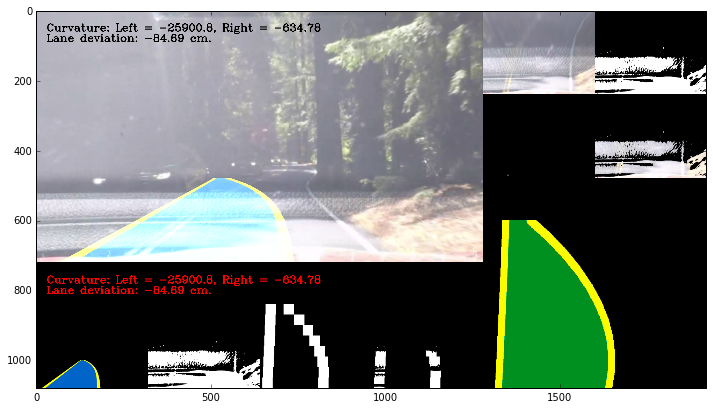

In [35]:
screen_out = 1
set_prev = 0
result_pipe = pipeline(image)
plt.figure(figsize=(12,8))
plt.imshow(result_pipe)
#cv2.imwrite(outdir+'/TEST_IMAGE_8.jpg',cv2.cvtColor(result_pipe, cv2.COLOR_BGR2RGB)) 

In [36]:
set_prev = 0
screen_out = 1
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4");
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False);

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



MoviePy: building video file challenge_video_output.mp4
----------------------------------------

Writing video into challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 388/388 [01:25<00:00,  4.64it/s]


Done writing video in challenge_video_output.mp4 !
Your video is ready !
Wall time: 1min 25s


In [ ]:
set_prev = 0
screen_out = 1
project_output_diag = 'project_video_output.mp4'
clip3 = VideoFileClip("project_video.mp4");
white_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output_diag, audio=False);

In [ ]:
project_output_diag = 'project_video_output_threshold_image.mp4'
clip3 = VideoFileClip("project_video.mp4");
white_clip = clip3.fl_image(threshold_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output_diag, audio=False);

In [25]:
set_prev = 0
screen_out = 1
project_output_diag = 'harder_challenge_video_out_1.mp4'
clip4 = VideoFileClip("harder_challenge_video.mp4");
white_clip = clip4.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output_diag, audio=False);

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



MoviePy: building video file harder_challenge_video_out_1.mp4
----------------------------------------

Writing video into harder_challenge_video_out_1.mp4


 50%|███████████████████████████████████████▋                                       | 578/1152 [02:14<02:05,  4.57it/s]C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 1152/1152 [04:23<00:00,  4.47it/s]


Done writing video in harder_challenge_video_out_1.mp4 !
Your video is ready !
Wall time: 4min 24s
